# Сборный проект 2 

## Описание задания

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

##  Предсказание уровня удовлетворенности сотрудника

### Обновим все библиотеки

In [1]:
!pip install --upgrade scikit-learn

In [2]:
!pip install matplotlib==3.5.0

     |████████████████████████████████| 11.2 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 59.8 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 724 kB/s  eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4


In [3]:
!pip install phik

### Загрузка данных

In [4]:
#импортируем все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# загружаем функцию для работы с метриками
from sklearn.metrics import make_scorer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder

#установим везде графики с одинаковым размером
plt.rcParams["figure.figsize"] = (10,4)

In [5]:
#загрузим все файлы с данными
train_df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features =  pd.read_csv('/datasets/test_features.csv')
test_target =  pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [6]:
#познакомимся с данными
print(train_df.head())
print("\n\n\n", '---------------------------')
print(test_features.head())
print("\n\n\n", '---------------------------')
print(test_target.head())

       id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20  



 ---------------------------
       id       dept   level workload

In [7]:
#познакомимся с данными
print(train_df.info())
print("\n\n\n", '---------------------------')
print(test_features.info())
print("\n\n\n", '---------------------------')
print(test_target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None



 ---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------

**Вывод по разделу:** 

Успешно загрузили данные в переменные с помощью библиотеки pandas. Ознакомились с датафреймами. 

### Предобработка данных

In [8]:
dataframes = [train_df, test_features, test_target]
#проверим каждый датафрейм на наличие пропусков
for i in dataframes:
    print(i.isna().sum(), '\n')

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64 

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

id                       0
job_satisfaction_rate    0
dtype: int64 



In [9]:
#удалим пропуски в двух датафреймах
#train_df = train_df.dropna()
#test_features = test_features.dropna()

In [10]:
#повторная проверка
#проверим каждый датафрейм на наличие пропусков
for i in dataframes:
    print(i.isna().sum(), '\n')

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64 

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

id                       0
job_satisfaction_rate    0
dtype: int64 



In [11]:
#проверим каждый датафрейм на наличие явных дубликатов
for i in dataframes:
    print(i.duplicated().sum(), '\n')

0 

0 

0 



In [12]:
#проверка df_1 на неявные дубликаты в столбцах
columns_df_1 = ['dept', 'level', 'workload', 'last_year_promo']
for i in columns_df_1:
    print(train_df[i].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']


In [13]:
train_df['level'] = train_df['level'].replace({'sinior' : 'senior'})

In [14]:
#проверка df_1 на неявные дубликаты в столбцах
columns_df_1 = ['dept', 'level', 'workload', 'last_year_promo']
for i in columns_df_1:
    print(train_df[i].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'senior' nan]
['medium' 'high' 'low']
['no' 'yes']


In [15]:
#проверка df_2 на неявные дубликаты в столбцах
columns_df_1 = ['dept', 'level', 'workload', 'last_year_violations']
for i in columns_df_1:
    print(test_features[i].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']


In [16]:
test_features[test_features['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [17]:
test_features[test_features['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [18]:
#test_features = test_features[test_features['dept'] != ' ']

In [19]:
#test_features = test_features[test_features['workload'] != ' ']

In [20]:
test_features['level'] = test_features['level'].replace({'sinior' : 'senior'})

In [21]:
#повторная проверка
#проверка df_2 на неявные дубликаты в столбцах
columns_df_1 = ['dept', 'level', 'workload', 'last_year_violations']
for i in columns_df_1:
    print(test_features[i].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'senior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']


**Вывод по разделу:**

Провели необходимую предобработку данных. Проверили датасеты на наличие пропусков, явных и неявных дубликатов, а также проверили оформление названий столбцов и формат данных в каждом столбце. Удалили пропуски. 

### Исследовательский анализ данных

#### Для первого датафрейма

In [22]:
#выведем списки для категориальных и количественных столбцов
cat_columns_df_1 = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
                    'last_year_violations', 'supervisor_evaluation']
num_columns_df_1 =['salary', 'job_satisfaction_rate']

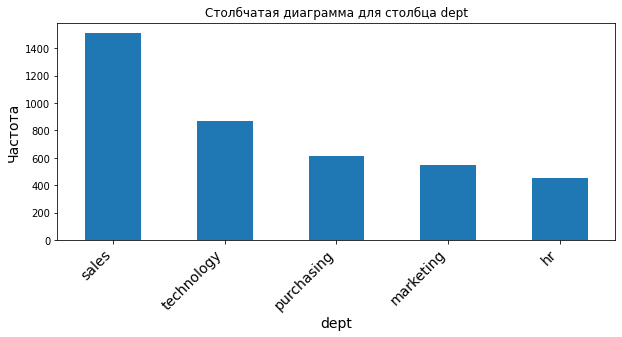

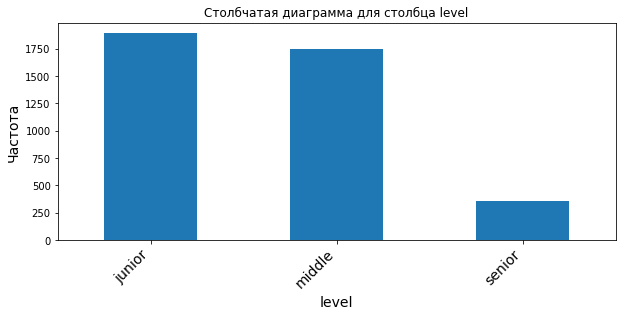

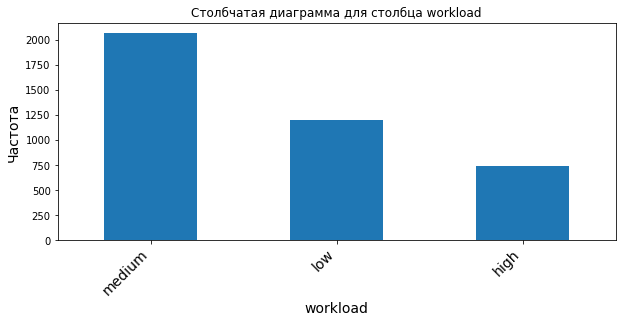

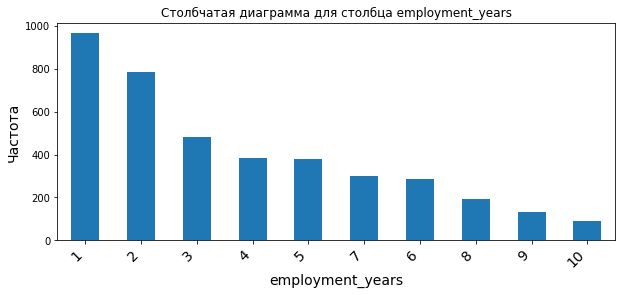

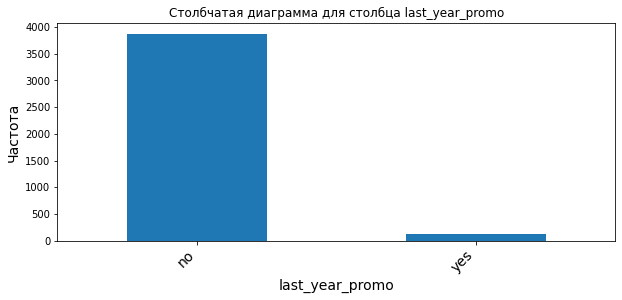

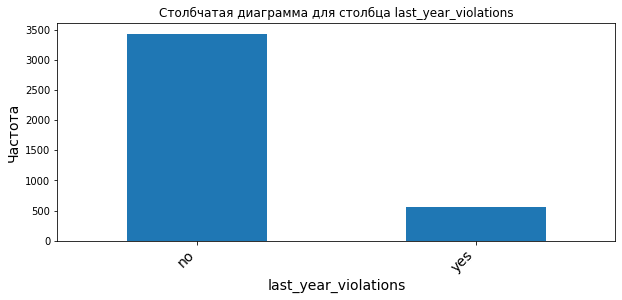

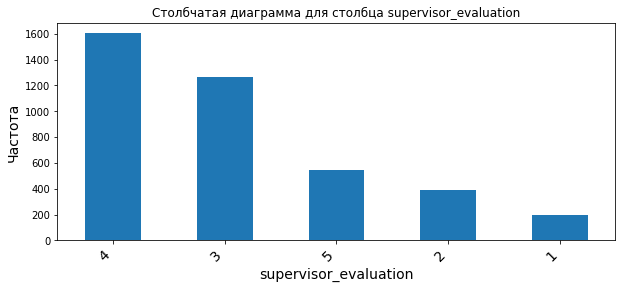

In [23]:
#с помощью цикла выведем гистограммы для каждого категориального столбца
for i in cat_columns_df_1:
    train_df[i].value_counts().plot(kind='bar')
    plt.ylabel('Частота', fontsize=14)
    plt.xlabel(i, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.title(f'Столбчатая диаграмма для столбца {i}')
    plt.show()

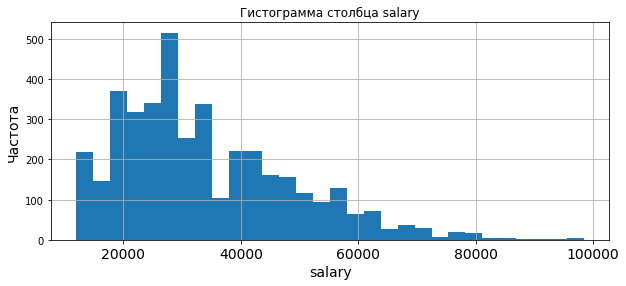

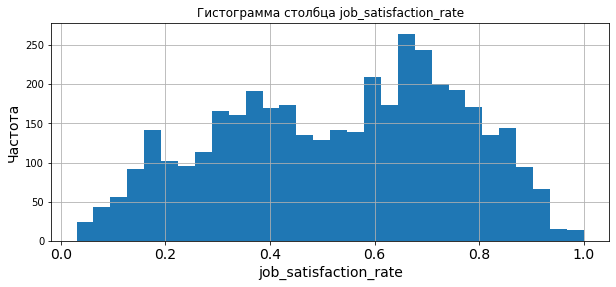

In [24]:
#с помощью цикла выведем гистограммы для каждого количественного столбца
for i in num_columns_df_1:
    train_df[i].hist(bins=30)
    plt.ylabel('Частота', fontsize=14)
    plt.xlabel(i, fontsize=14)
    plt.title(f'Гистограмма столбца {i}')
    plt.xticks(fontsize=14)
    plt.show()

аномалий не обнаружено

#### Для второго датафрейма

In [25]:
#выведем списки для категориальных и количественных столбцов
cat_columns_df_2 = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
                    'last_year_violations', 'supervisor_evaluation']
num_columns_df_2 =['salary']

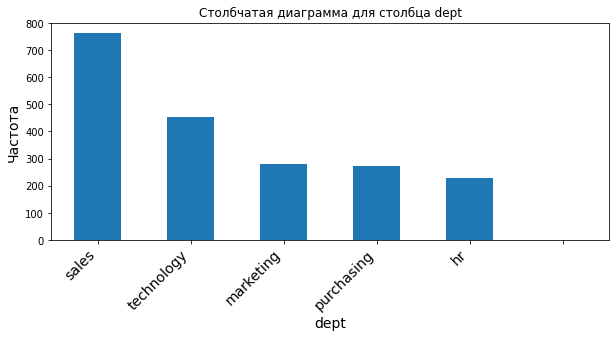

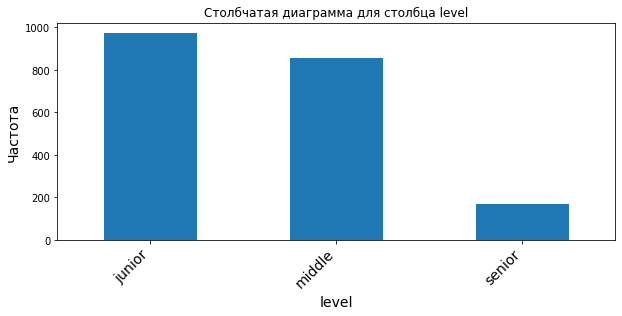

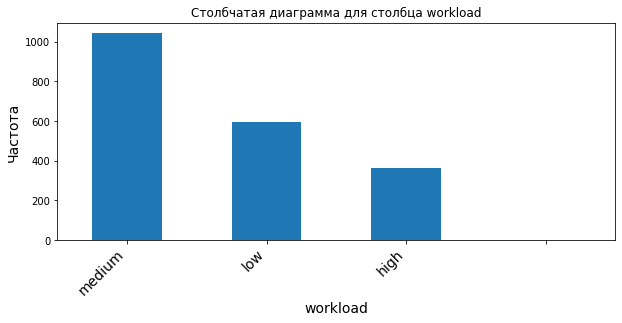

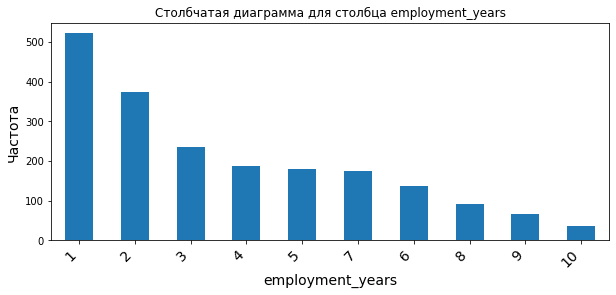

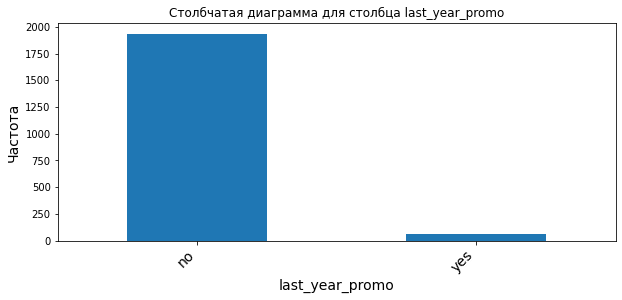

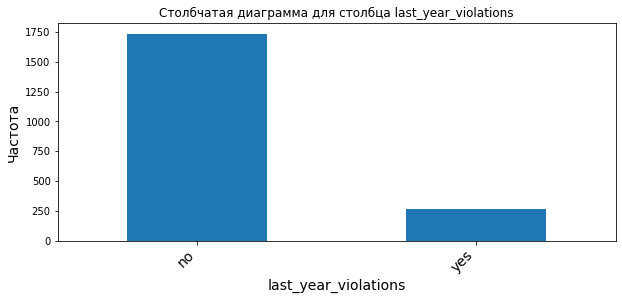

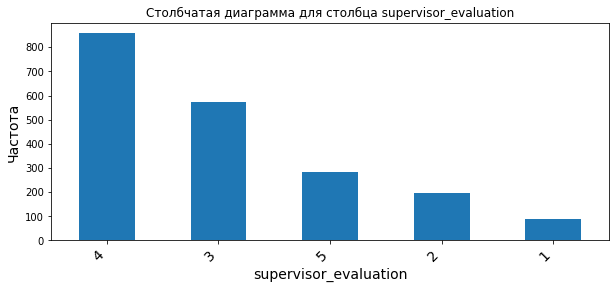

In [26]:
#с помощью цикла выведем гистограммы для каждого категориального столбца
for i in cat_columns_df_2:
    test_features[i].value_counts().plot(kind='bar')
    plt.ylabel('Частота', fontsize=14)
    plt.xlabel(i, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.title(f'Столбчатая диаграмма для столбца {i}')
    plt.show()

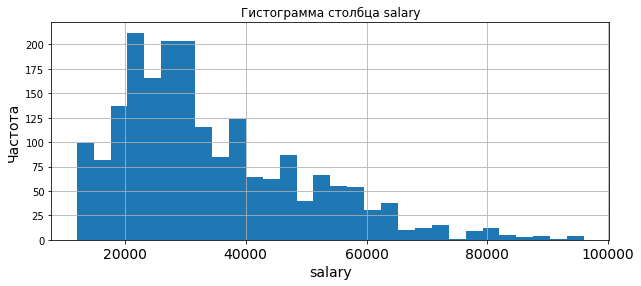

In [27]:
#с помощью цикла выведем гистограммы для каждого количественного столбца
for i in num_columns_df_2:
    test_features[i].hist(bins=30)
    plt.ylabel('Частота', fontsize=14)
    plt.xlabel(i, fontsize=14)
    plt.title(f'Гистограмма столбца {i}')
    plt.xticks(fontsize=14)
    plt.show()

аномалий не обнаружено

#### Для третьего датафрейма

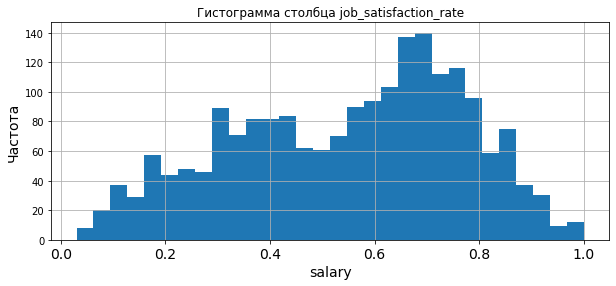

In [28]:
#выведем гистограмму для столбца job_satisfaction_rate
test_target['job_satisfaction_rate'].hist(bins=30)
plt.ylabel('Частота', fontsize=14)
plt.xlabel(i, fontsize=14)
plt.title(f'Гистограмма столбца job_satisfaction_rate')
plt.xticks(fontsize=14)
plt.show()

аномалий не обнаружено

Комментарий по особенностям распределений признаков: 

Мы видим, что согласно графикам, больше всего людей работали/работают в отделе продаж, большинство работников уровня senior и middle, также видно, что согласно столбцам last_year_violations и last_year_promo не было ни повышений, ни значительного количества нарушений за последний год. Зарплата распределена, в основном от 20 до 60 тыс. 

На графиках видно что выборки (train и test) очень схожи по своему распределению, что является хорошим знаком для обучения наших моделей - данные консистентны. 

In [29]:
dataframe_2_for_phik = pd.merge(test_features, test_target, on='id', how='left')

In [30]:
interval_cols = ['salary', 'job_satisfaction_rate']

In [31]:
#так как мы будем обучать одну линейную модель, то необходимо проверить все входные признаки на мультиколлинеарность. 
phik_overview = train_df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)

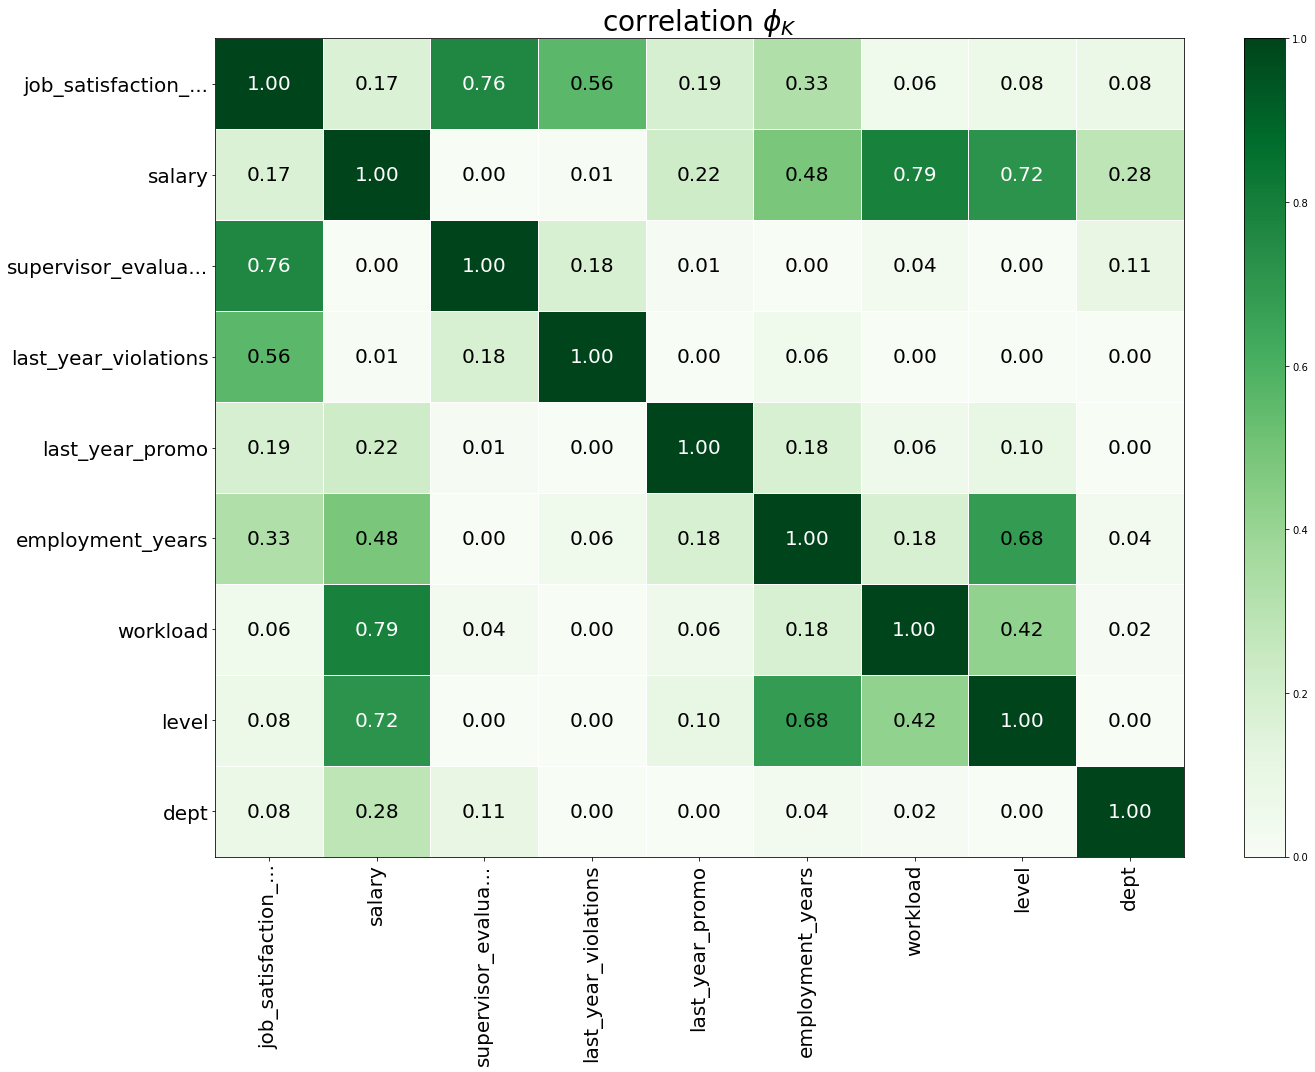

In [32]:
# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=2,
    figsize=(20, 15)
) 

Вывод по графику: мультиколлинеарности не обнаружено

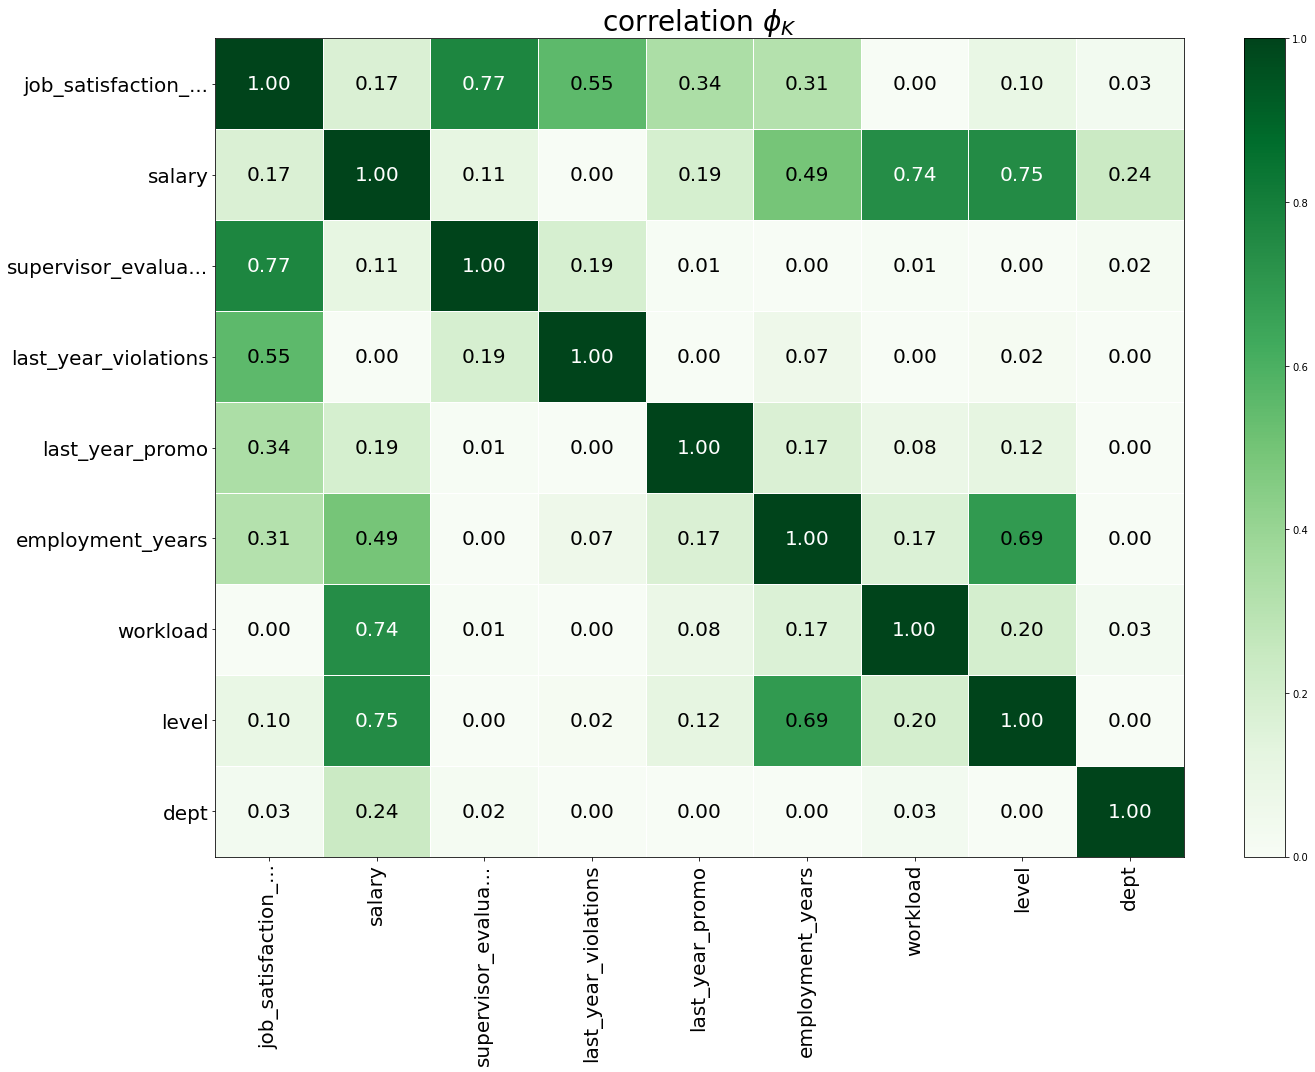

In [33]:
#так как мы будем обучать одну линейную модель, то необходимо проверить все входные признаки на мультиколлинеарность. 
phik_overview_2 = dataframe_2_for_phik.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview_2.values,
    x_labels=phik_overview_2.columns,
    y_labels=phik_overview_2.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=2,
    figsize=(20, 15)
) 

Вывод по графику: мультиколлинеарности не обнаружено

**Вывод по разделу:**

Проверили все категориальные и количественные столбцы на аномалии во всех датафреймах. Аномалий не было обнаружено, ни в одном датафрейме.
Для построения  и выбора подходящей модели, которая будет предсказывать уровень удовлетворенности сотрудника, необходимо будет провести кодирование и шкалирование категориальных и количественных данных соотвественно. 

### Подготовка данных

In [34]:
train_df = train_df.sort_values('id')

In [35]:
train_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
560,100954,purchasing,junior,low,1,no,no,4,15600,0.60
1124,101057,sales,junior,low,1,no,yes,4,19200,0.45
1509,101074,sales,junior,medium,2,no,no,2,20400,0.36
2106,101081,sales,middle,low,2,no,no,4,28800,0.66
405,101129,technology,junior,medium,1,no,no,4,34800,0.71


In [36]:
test_data_X = pd.merge(test_features, test_target['id'], on='id', how='inner')

In [37]:
data_y_test = pd.merge(test_target, test_data_X['id'], on='id', how='inner')

In [38]:
test_data_X = test_data_X.sort_values('id')

In [39]:
test_data_X.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [40]:
data_y_test = data_y_test.sort_values('id')

In [41]:
data_y_test.head()

,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


In [42]:
#подготовим функцию для нашей метрики
def smape(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(error / scale) * 100

In [43]:
scorer = make_scorer(smape, greater_is_better=False)

In [44]:
#подготовим пайплайн
#построим модели и проверим их гиперпараметры с помощью пайплайна на тренировочной выборке

RANDOM_STATE = 42

X_train = train_df.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_df['job_satisfaction_rate']

In [45]:
X_test = test_data_X.drop(['id'], axis=1)
y_test = data_y_test['job_satisfaction_rate']

# создаём списки с названиями признаков

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

num_columns = ['salary']

# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe = Pipeline(
    [
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    
    ]
    )

In [46]:
# создаём пайплайн для подготовки признаков из списка ord_columns: Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_random = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 10, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 5],
        'models__ccp_alpha': [0.0, 0.1, 0.2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
     {
        'models': [SVR()],
        'models__C': [1, 10],
        'models__kernel': ['linear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()]
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_random, 
    cv=5,
    n_iter = 5,
    random_state=RANDOM_STATE,
    scoring=scorer,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -randomized_search.best_score_)

Лучшая модель и её параметры Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                               

In [47]:
# извлекаем модель и трансформер из обученной модели
model = randomized_search.best_estimator_.named_steps['models']
pre = randomized_search.best_estimator_.named_steps['preprocessor']
# трансформируем данные
X_train_processed = pre.transform(X_train)
X_test_processed  = pre.transform(X_test)
# сохраняем признаков после всех трансформаций
feature_names = pre.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_processed,  columns=feature_names)

model.fit(X_train_df, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


DecisionTreeRegressor(min_samples_split=10, random_state=42)

In [48]:
y_pred = model.predict(X_test_df)

In [49]:
y_test = y_test.to_numpy()

In [50]:
scoring_best_model = smape(y_test, y_pred)

In [51]:
print('Метрика лучшей модели на тестовой выборке:', scoring_best_model)

Метрика лучшей модели на тестовой выборке: 13.648743490444874


**Вывод по разделу:**

Успешно сконструировали пайплайн с различными гиперпараметрами трех моделей. Лучше всего справилась модель DecisionTreeRegressor c гиперпараметрами (min_samples_split=10, random_state=42). Метрика на тестовой выборке составила 13,64.

##  Предсказание увольнения сотрудника из компании

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

### Загрузка данных

In [52]:
#загрузка данных 
df_1 = pd.read_csv('/datasets/train_quit.csv') #тренировочная выборка
df_2 = pd.read_csv('/datasets/test_features.csv') #входные признаки тестовой выборки
df_3 = pd.read_csv('/datasets/test_target_quit.csv') #целевой признак тестовой выборки

In [53]:
#познакомимся с данными
df_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [54]:
#познакомимся с данными
df_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [55]:
#познакомимся с данными
df_3.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [56]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [57]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [58]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Вывод по разделу:**

Успешно загрузили датасеты в наши переменные и познакомились с тремя датафреймами.

### Предобработка данных

In [59]:
dataframes_2 = [df_1, df_2, df_3]
#проверим каждый датафрейм на наличие пропусков
for k in dataframes_2:
    print(k.isna().sum(), '\n')

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64 

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

id      0
quit    0
dtype: int64 



In [60]:
#повторная проверка
#проверим каждый датафрейм на наличие пропусков
for k in dataframes_2:
    print(k.isna().sum(), '\n')

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64 

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

id      0
quit    0
dtype: int64 



In [61]:
#проверим каждый датафрейм на наличие явных дубликатов
for k in dataframes_2:
    print(k.duplicated().sum(), '\n')

0 

0 

0 



In [62]:
#проверка df_1 на неявные дубликаты в столбцах
columns_for_df_1 = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
for k in columns_for_df_1:
    print(df_1[k].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [63]:
df_1['level'] = df_1['level'].replace({'sinior' : 'senior'})

In [64]:
#повторная проверка df_1 на неявные дубликаты в столбцах
columns_for_df_1 = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
for k in columns_for_df_1:
    print(df_1[k].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'senior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [65]:
#проверка df_1 на неявные дубликаты в столбцах
columns_for_df_2 = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for k in columns_for_df_2:
    print(df_2[k].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


In [66]:
df_2['level'] = df_2['level'].replace({'sinior' : 'senior'})

In [67]:
#повторная проверка
#проверка df_1 на неявные дубликаты в столбцах
columns_for_df_2 = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for k in columns_for_df_2:
    print(df_2[k].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'senior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


In [68]:
df_3['quit'].unique()

array(['yes', 'no'], dtype=object)

**Вывод по разделу:**

Провели необходимую предобработку данных. Проверили датасеты на наличие пропусков, явных и неявных дубликатов, а также проверили оформление названий столбцов и формат данных в каждом столбце. Удалили пропуски. 

### Исследовательский анализ данных

#### Для первого датафрейма

In [69]:
#выведем списки для категориальных и количественных столбцов
cat_columns_for_df_1 = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
                    'last_year_violations', 'supervisor_evaluation', 'quit']
num_columns_for_df_1 =['salary']

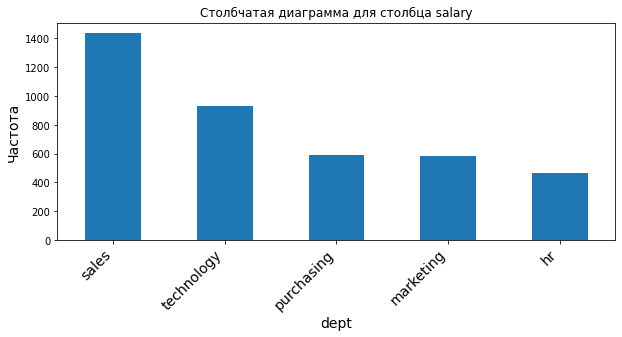

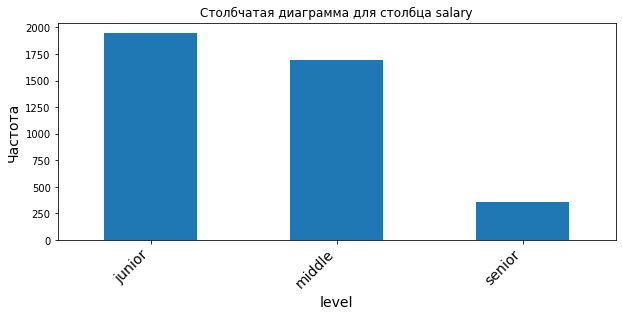

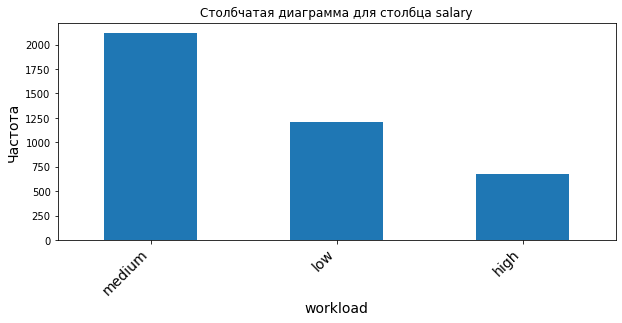

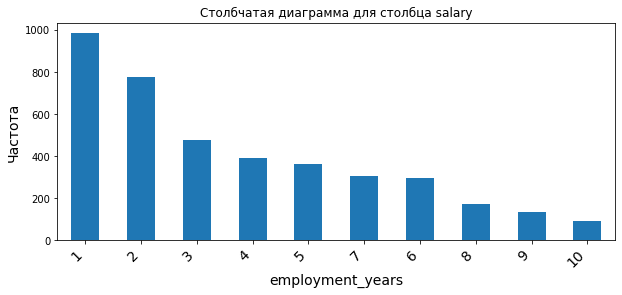

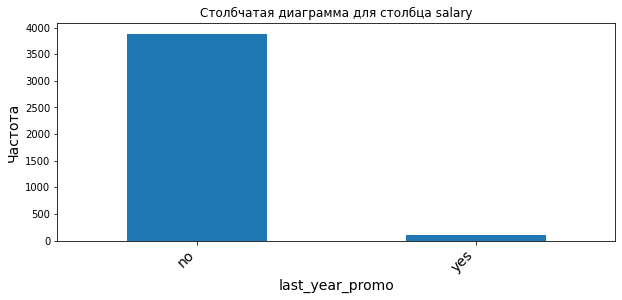

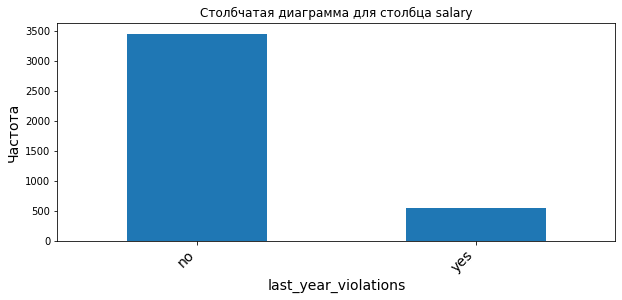

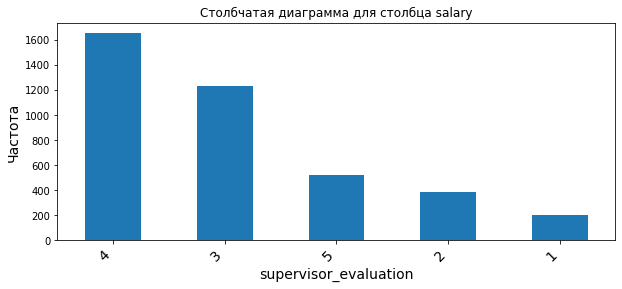

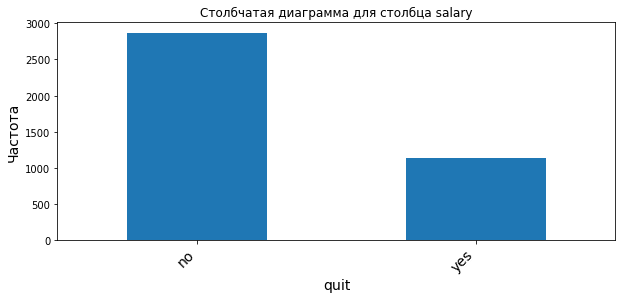

In [70]:
#с помощью цикла выведем гистограммы для каждого категориального столбца
for k in cat_columns_for_df_1:
    df_1[k].value_counts().plot(kind='bar')
    plt.ylabel('Частота', fontsize=14)
    plt.xlabel(k, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.title(f'Столбчатая диаграмма для столбца {i}')
    plt.show()

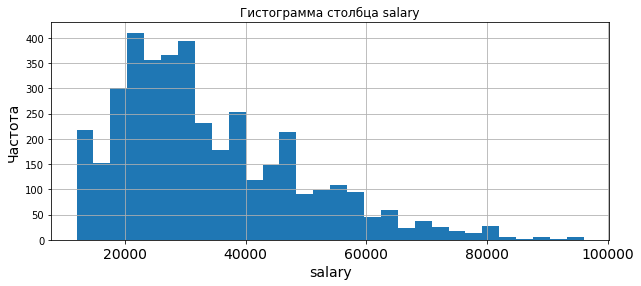

In [71]:
#с помощью цикла выведем гистограммы для каждого количественного столбца
for k in num_columns_for_df_1:
    df_1[k].hist(bins=30)
    plt.ylabel('Частота', fontsize=14)
    plt.xlabel(k, fontsize=14)
    plt.title(f'Гистограмма столбца {i}')
    plt.xticks(fontsize=14)
    plt.show()

аномалий не обнаружно

#### Для второго датафрейма

In [72]:
#выведем списки для категориальных и количественных столбцов
cat_columns_for_df_2 = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 
                    'last_year_violations', 'supervisor_evaluation']
num_columns_for_df_2 =['salary']

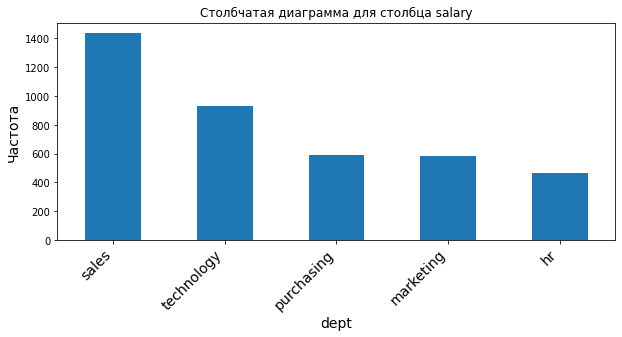

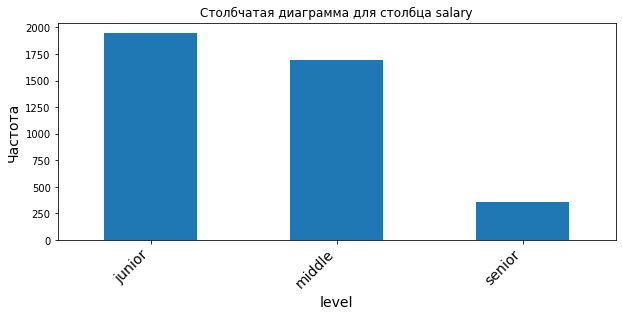

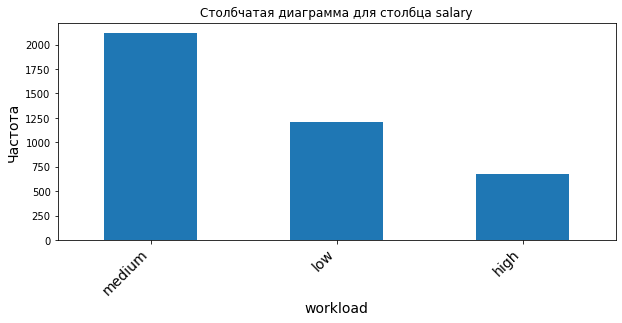

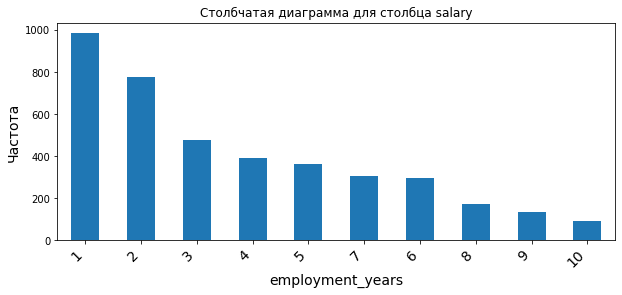

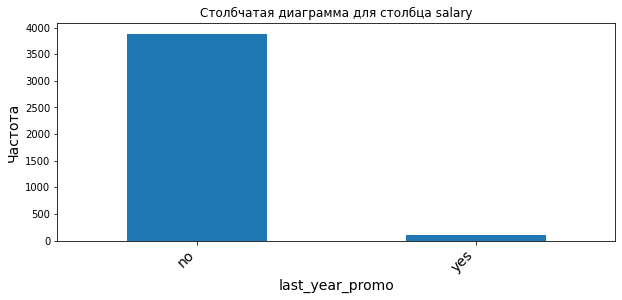

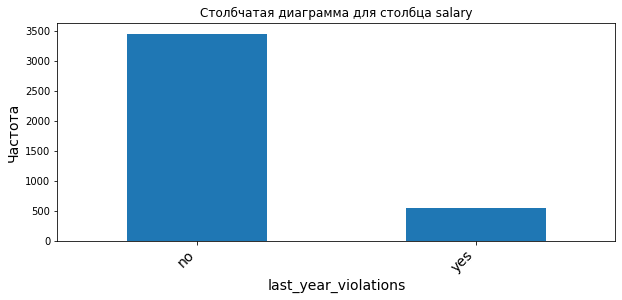

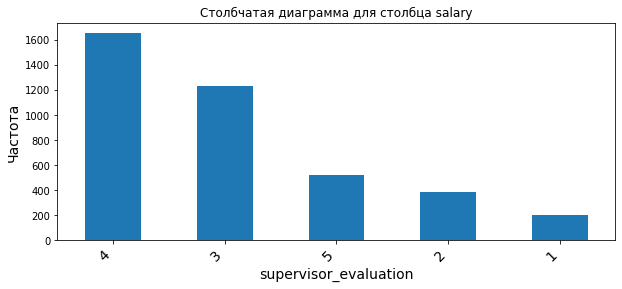

In [73]:
#с помощью цикла выведем гистограммы для каждого категориального столбца
for k in cat_columns_for_df_2:
    df_1[k].value_counts().plot(kind='bar')
    plt.ylabel('Частота', fontsize=14)
    plt.xlabel(k, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.title(f'Столбчатая диаграмма для столбца {i}')
    plt.show()

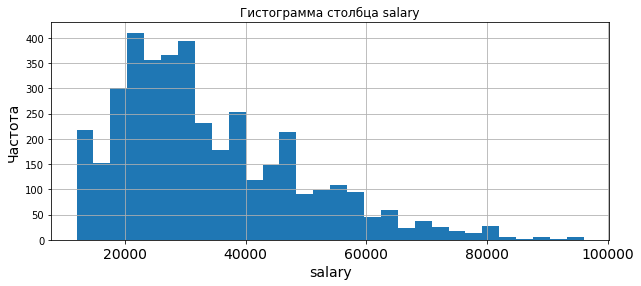

In [74]:
#с помощью цикла выведем гистограммы для каждого количественного столбца
for k in num_columns_for_df_2:
    df_1[k].hist(bins=30)
    plt.ylabel('Частота', fontsize=14)
    plt.xlabel(k, fontsize=14)
    plt.title(f'Гистограмма столбца {i}')
    plt.xticks(fontsize=14)
    plt.show()

аномалий не обнаружено

#### Для третьего датафрейма

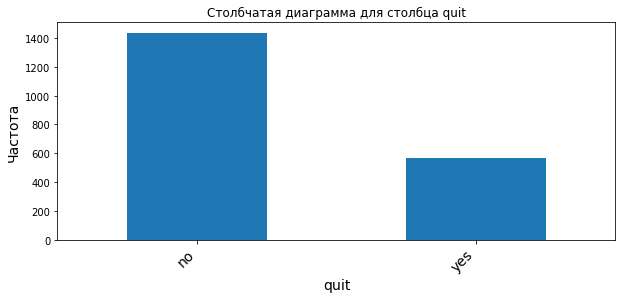

In [75]:
df_3['quit'].value_counts().plot(kind='bar')
plt.ylabel('Частота', fontsize=14)
plt.xlabel('quit', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title(f'Столбчатая диаграмма для столбца quit')
plt.show()

аномалий не обнаружено

Комментарий по особенностям распределений признаков: 

Мы видим, что согласно графикам, больше всего людей работали/работают в отделе продаж, большинство работников уровня Зарплата распределена, в основном от 20 до 80 тыс. 

На графиках видно что выборки (train и test) очень схожи по своему распределению, что является хорошим знаком для обучения наших моделей - данные консистентны. 

#### Портрет уволившегося сотрудника

In [76]:
#получим срез данных по первому датафрейму и со значением столбца quit - yes, и номера, уволившихся сотрудников
resited_employee = df_1.query('quit == "yes"')

In [77]:
stayed_employee = df_1.query('quit == "no"')

In [78]:
#таблица всех уволившихся сотрудников 
resited_employee.sort_values('id', ascending=True)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
2600,100222,sales,junior,medium,3,no,no,2,20400,yes
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes
2657,100858,sales,junior,medium,2,no,no,4,25200,yes
3072,100969,marketing,junior,medium,2,no,no,3,26400,yes
3552,102630,technology,junior,medium,2,no,no,2,30000,yes
...,...,...,...,...,...,...,...,...,...,...
2737,994739,hr,junior,medium,1,no,yes,3,25200,yes
841,996445,sales,junior,low,2,no,no,1,12000,yes
3426,997272,hr,junior,medium,1,no,no,1,25200,yes
3701,999003,hr,middle,low,3,no,no,2,24000,yes


In [79]:
for i in resited_employee.drop(['id', 'salary'], axis=1).columns:
    print(resited_employee[i].value_counts(normalize=True))
    print('\n')

sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: dept, dtype: float64


junior    0.889184
middle    0.095745
senior    0.015071
Name: level, dtype: float64


low       0.460106
medium    0.432624
high      0.107270
Name: workload, dtype: float64


1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
8     0.002660
9     0.002660
10    0.002660
Name: employment_years, dtype: float64


no     0.999113
yes    0.000887
Name: last_year_promo, dtype: float64


no     0.797872
yes    0.202128
Name: last_year_violations, dtype: float64


3    0.463652
4    0.253546
2    0.145390
1    0.084220
5    0.053191
Name: supervisor_evaluation, dtype: float64


yes    1.0
Name: quit, dtype: float64




In [80]:
print(f'Среднее значение уровня зарплаты у неуволившихся сотрудников {stayed_employee["salary"].mean()}, у уволившихся - {resited_employee["salary"].mean()}')

Среднее значение уровня зарплаты у неуволившихся сотрудников 37702.22841225627, у уволившихся - 23885.106382978724


**Вывод по разделу:**

Типичный портрет уволившегося сотрудника таков: Это сотрудник работающий в отдел продаж, уровня junior, с низким уровнем загруженности, работающий менее 2-х лет, без повышения и без нарушений за последний год, а также с уровнем зарплаты ниже 30 тыс рублей. 

#### Связь между  уровенем удовлетворённости сотрудника работой в компании и его увольнением

In [81]:
corr_sat_rate = pd.merge(test_target, df_3,  on='id', how='inner')

In [82]:
corr_sat_rate

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes
...,...,...,...
1995,405257,0.28,no
1996,370925,0.21,yes
1997,857722,0.39,no
1998,303402,0.26,yes


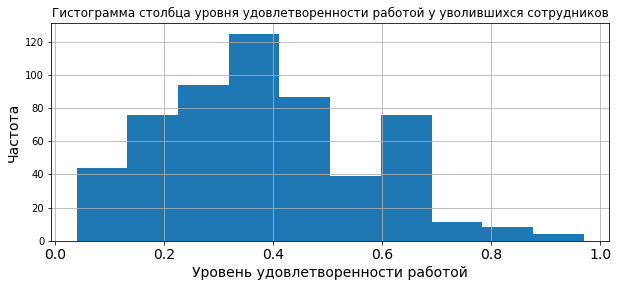

In [83]:
#уволившийся сотрудники
corr_sat_rate[corr_sat_rate['quit'] == 'yes'].sort_values('job_satisfaction_rate')['job_satisfaction_rate'].hist()
plt.ylabel('Частота', fontsize=14)
plt.xlabel('Уровень удовлетворенности работой', fontsize=14)
plt.title(f'Гистограмма столбца уровня удовлетворенности работой у уволившихся сотрудников')
plt.xticks(fontsize=14)
plt.show()

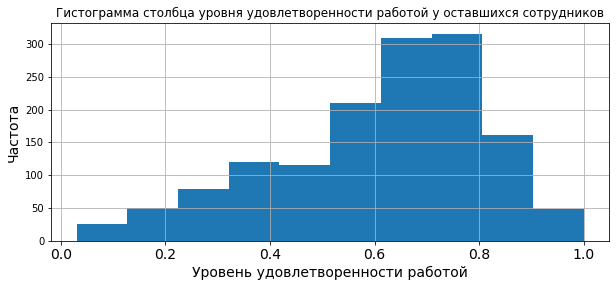

In [84]:
#оставшийся сотрудники
corr_sat_rate[corr_sat_rate['quit'] == 'no'].sort_values('job_satisfaction_rate')['job_satisfaction_rate'].hist()
plt.ylabel('Частота', fontsize=14)
plt.xlabel('Уровень удовлетворенности работой', fontsize=14)
plt.title(f'Гистограмма столбца уровня удовлетворенности работой у оставшихся сотрудников')
plt.xticks(fontsize=14)
plt.show()

**Вывод по разделу:**

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Действительно, данная гипотеза потвердилась. 

### Добавление нового входного признака

In [85]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
560,purchasing,junior,low,1,no,no,4,15600
1124,sales,junior,low,1,no,yes,4,19200
1509,sales,junior,medium,2,no,no,2,20400
2106,sales,middle,low,2,no,no,4,28800
405,technology,junior,medium,1,no,no,4,34800


In [86]:
#подготовка данных из второй задачи к модели первой
X_train_2 = df_1.drop(['quit'], axis=1)

In [87]:
X_train_2 #входные признаки готовы

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,723290,sales,middle,high,2,no,no,4,54000
1,814010,sales,junior,medium,2,no,no,4,27600
2,155091,purchasing,middle,medium,5,no,no,1,37200
3,257132,sales,junior,medium,2,no,yes,3,24000
4,910140,marketing,junior,medium,2,no,no,5,25200
...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400
3996,672059,sales,middle,high,9,no,no,4,52800
3997,536432,purchasing,junior,low,2,no,yes,4,12000
3998,692133,purchasing,middle,medium,2,no,no,4,33600


In [88]:
# извлекаем модель и трансформер из обученной модели
model = randomized_search.best_estimator_.named_steps['models']
pre = randomized_search.best_estimator_.named_steps['preprocessor']
# трансформируем данные
X_train_processed_2 = pre.transform(X_train_2)
# сохраняем признаков после всех трансформаций
feature_names = pre.get_feature_names_out()
X_train_df_2 = pd.DataFrame(X_train_processed_2, columns=feature_names)

sat_rate_pred_train = model.predict(X_train_df_2)

In [89]:
sat_rate_pred_train

array([0.63875   , 0.82611111, 0.34      , ..., 0.54875   , 0.51571429,
       0.53      ])

In [90]:
predictions_df_train = pd.DataFrame(sat_rate_pred_train, columns=['job_satisfaction_rate_pred'], index=X_train_df_2.index)

In [91]:
predictions_df_train.head()

,job_satisfaction_rate_pred
0,0.638750
1,0.826111
2,0.340000
3,0.334444
4,0.690000


In [92]:
#проведем те же манипуляции с тестовыми данными

In [93]:
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,hr,junior,low,2,no,no,4,19200
852,marketing,junior,low,4,no,no,4,16800
848,purchasing,middle,high,5,no,no,4,55200
524,sales,middle,medium,5,no,no,4,43200
476,sales,middle,high,6,no,no,4,48000


In [94]:
X_test_2 = df_2.drop(['id'], axis=1)

In [95]:
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,marketing,junior,medium,2,no,no,5,28800
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
4,hr,middle,medium,5,no,no,5,40800


In [96]:
# трансформируем данные
X_test_processed_2 = pre.transform(X_test_2)
# сохраняем признаков после всех трансформаций
feature_names = pre.get_feature_names_out()
X_test_df_2 = pd.DataFrame(X_test_processed_2, columns=feature_names)

sat_rate_pred_test = model.predict(X_test_df_2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [97]:
predictions_df_test = pd.DataFrame(sat_rate_pred_test, columns=['job_satisfaction_rate_pred'], index=X_test_df_2.index)

In [98]:
predictions_df_test.head()

,job_satisfaction_rate_pred
0,0.883333
1,0.682222
2,0.657143
3,0.655000
4,0.825556


In [99]:
#добавим теперь значения в общие таблицы
df_1['job_satisfaction_rate_pred'] = predictions_df_train

In [100]:
df_2['job_satisfaction_rate_pred'] = predictions_df_test

In [101]:
#проверим таблицы
df_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.638750
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.826111
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.334444
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [102]:
df_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.883333
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.825556


**Вывод по разделу:**

Успешно добавили новый признак в датафреймы.

In [103]:
interval_cols = ['salary', 'job_satisfaction_rate_pred']

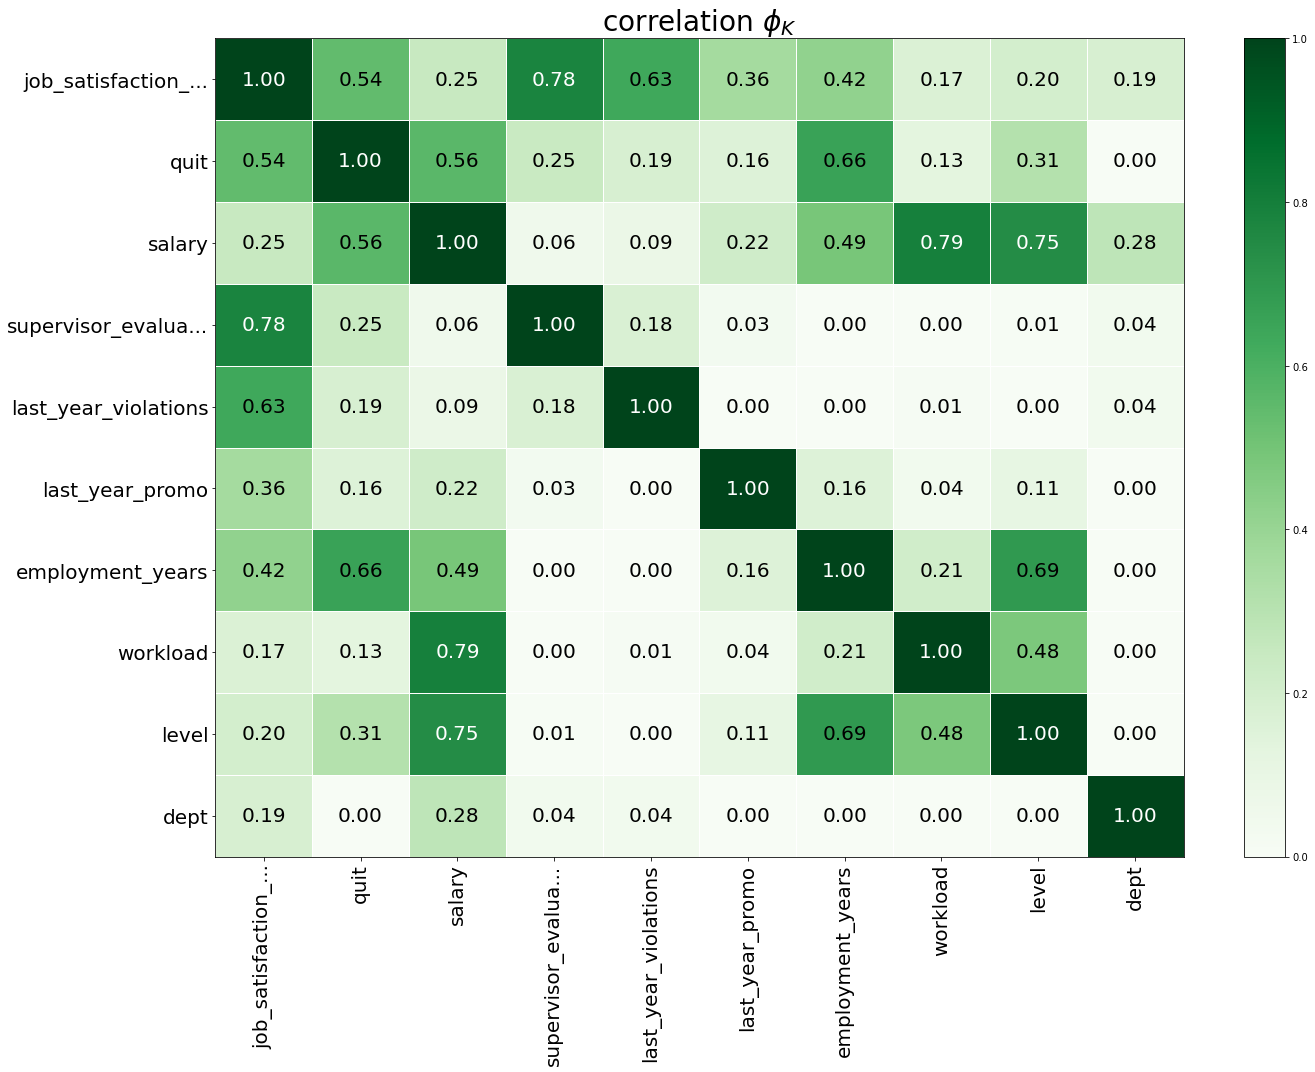

In [104]:
#необходимо проверить все входные признаки на мультиколлинеарность. 
phik_overview_3 = df_1.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview_3.values,
    x_labels=phik_overview_3.columns,
    y_labels=phik_overview_3.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=2,
    figsize=(20, 15)
) 

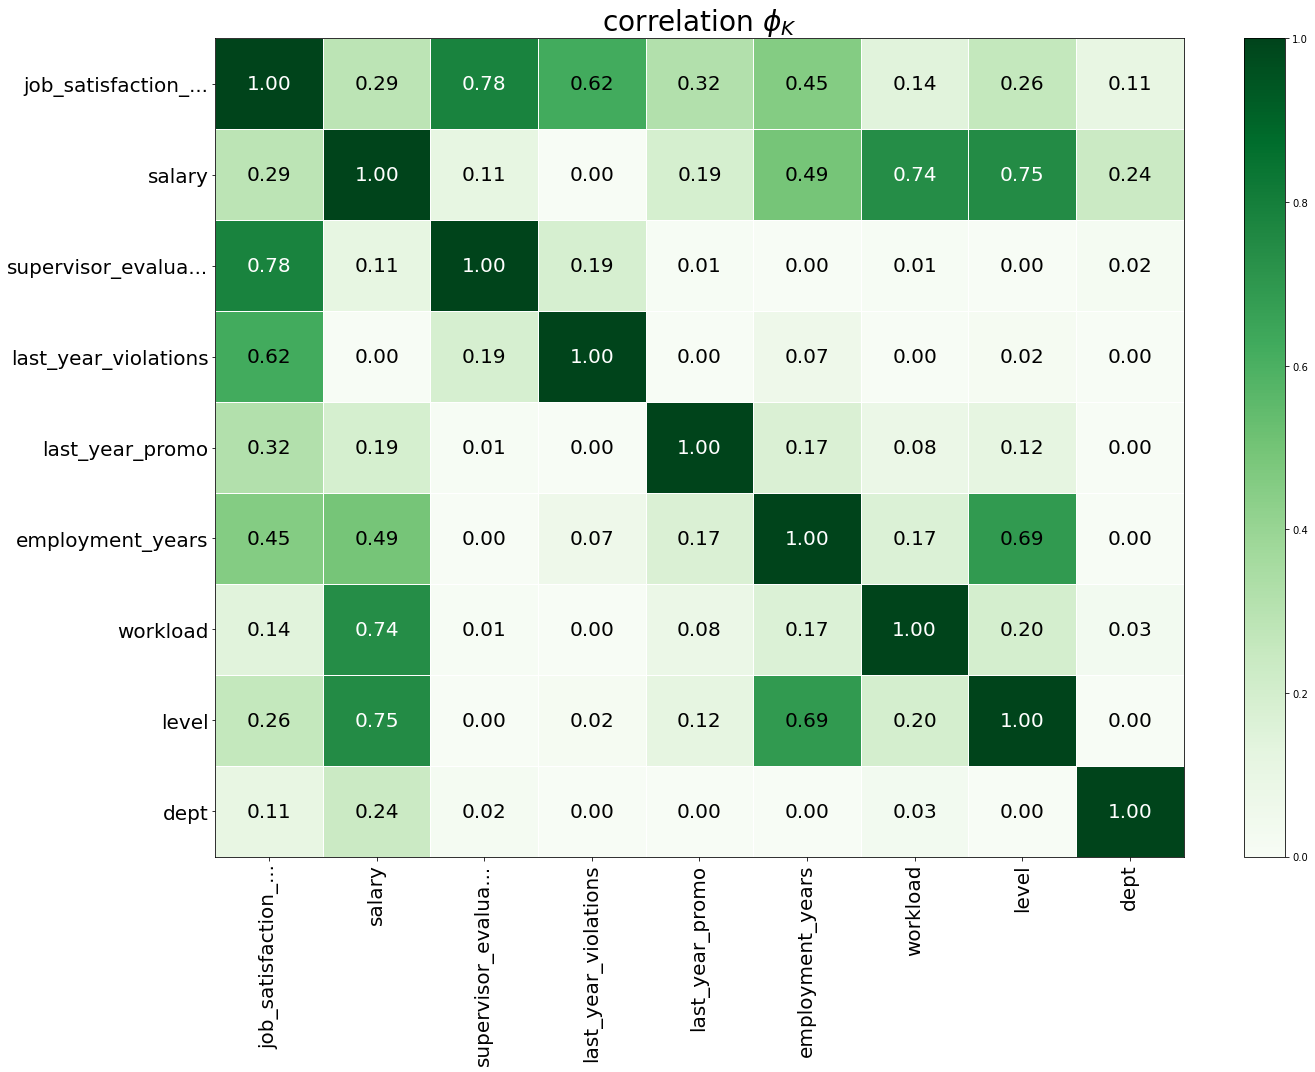

In [105]:
#необходимо проверить все входные признаки на мультиколлинеарность. 
phik_overview_4 = df_2.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview_4.values,
    x_labels=phik_overview_4.columns,
    y_labels=phik_overview_4.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=2,
    figsize=(20, 15)
) 

### Подготовка данных и обучение модели

In [106]:
df_1 = df_1.sort_values('id')
df_2 = df_2.sort_values('id')
df_3 = df_3.sort_values('id')

In [107]:
df_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
2600,100222,sales,junior,medium,3,no,no,2,20400,yes,0.345714
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.311667
2455,100469,marketing,junior,medium,1,no,no,4,28800,no,0.630000
1592,100601,technology,middle,high,4,no,no,4,68400,no,0.666667
2657,100858,sales,junior,medium,2,no,no,4,25200,yes,0.823636


In [108]:
df_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
1172,100298,hr,junior,low,2,no,no,4,19200,0.837500
852,100480,marketing,junior,low,4,no,no,4,16800,0.852000
848,100503,purchasing,middle,high,5,no,no,4,55200,0.746667
524,100610,sales,middle,medium,5,no,no,4,43200,0.813333
476,100692,sales,middle,high,6,no,no,4,48000,0.700000


In [109]:
df_3.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


In [110]:
label_encoder = LabelEncoder()

In [111]:
df_1['quit_code'] = label_encoder.fit_transform(df_1['quit'])

In [112]:
df_3['quit_code'] = label_encoder.transform(df_3['quit'])

In [113]:
df_3 = pd.merge(df_3, df_2['id'], on='id', how='inner')

In [114]:
df_3.head()

,id,quit,quit_code
0,100298,no,0
1,100480,no,0
2,100503,no,0
3,100610,no,0
4,100692,no,0


In [115]:
test_dataframe = pd.merge(df_2, df_3, on='id', how='inner')

In [116]:
test_dataframe.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred,quit,quit_code
0,100298,hr,junior,low,2,no,no,4,19200,0.837500,no,0
1,100480,marketing,junior,low,4,no,no,4,16800,0.852000,no,0
2,100503,purchasing,middle,high,5,no,no,4,55200,0.746667,no,0
3,100610,sales,middle,medium,5,no,no,4,43200,0.813333,no,0
4,100692,sales,middle,high,6,no,no,4,48000,0.700000,no,0


In [117]:
#подготовим пайплайн
#построим модели и проверим их гиперпараметры с помощью пайплайна на тренировочной выборке

RANDOM_STATE = 42

X_train_2 = df_1.drop(['id', 'quit', 'quit_code'], axis=1)
y_train_2 = df_1['quit_code']

X_test_2 = test_dataframe.drop(['id', 'quit', 'quit_code'], axis=1)
y_test_2 = test_dataframe['quit_code']

In [118]:
# создаём списки с названиями признаков

ohe_columns_2 = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns_2 = ['level', 'workload']

num_columns_2 = ['salary', 'job_satisfaction_rate_pred']

# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe_2 = Pipeline(
    [
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: Ordinal-кодирование
ord_pipe_2 = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
      ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor_2 = ColumnTransformer(
    [('ohe', ohe_pipe_2, ohe_columns_2),
     ('ord', ord_pipe_2, ord_columns_2),
     ('num', MinMaxScaler(), num_columns_2)
    ], 
    remainder='passthrough'
)

pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_2 = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 30),
        'models__min_samples_split': range(2, 100),
        'models__min_samples_leaf': range(1, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': np.logspace(-4, 4, num=10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE, 
            kernel='poly',
            probability=True
        )],
        'models__C': np.logspace(-30, 30, num=10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=10,
    n_iter = 15,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

randomized_search_2.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_2.best_score_)

Лучшая модель и её параметры Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                               

In [119]:
# извлекаем модель и трансформер из обученной модели
model_2 = randomized_search_2.best_estimator_.named_steps['models']
pre_2 = randomized_search_2.best_estimator_.named_steps['preprocessor']
# трансформируем данные
X_train_processed_3 = pre_2.transform(X_train_2)
X_test_processed_3  = pre_2.transform(X_test_2)
# сохраняем признаков после всех трансформаций
feature_names = pre_2.get_feature_names_out()
X_train_df_3 = pd.DataFrame(X_train_processed_3, columns=feature_names)
X_test_df_3  = pd.DataFrame(X_test_processed_3,  columns=feature_names)

model_2.fit(X_train_df_3, y_train_2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


DecisionTreeClassifier(max_depth=23, min_samples_leaf=14, min_samples_split=6,
                       random_state=42)

In [120]:
y_test_2 = y_test_2.to_numpy()

In [121]:
y_pred_2 = model_2.predict_proba(X_test_df_3)[:, 1]

In [122]:
scoring_best_model_2 = roc_auc_score(y_test_2, y_pred_2)

In [123]:
print('Метрика лучшей модели на тестовой выборке', scoring_best_model_2)

Метрика лучшей модели на тестовой выборке 0.9236341591102156


**Вывод по разделу:**

Успешно обучили как минимум три модели. Как минимум для двух из них подобрали гиперпараметры. Проверили качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке прошел успешно. 

### Выводы: 

Успешно провели обучение модели и отобрали лучшую. Лучшая модель - DecisionTreeClassifier(max_depth=4, min_samples_leaf=17, min_samples_split=6, random_state=42). 

Этапы работы включали себя загрузку данных их предобработку, исследовательский анализ данных, построение моделей и подбор лучших гиперпараметров методом RandomSearchCV. 

В ходе работы, выявили типичный портрет уволившегося сотрудника. Им оказался сотрудник, который работает в отделе продаж, уровня junior, с низким уровнем загруженности, работающий менее 2-х лет, без повышения и без нарушений за последний год. Следовательно, необходимо для удержания сотрудников, давать им большую загрузку и интересных работ, а также обратить особое внимание на отдел продаж.   